### This is a project for the Kaggle competition with the Titanic Dataset 
The task is straightforward: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [64]:
# analitics
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

# machine learning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

###Loading data

In [65]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combined = [train_df, test_df]

In [66]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [67]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


###Preprocessing data

Let's take a look at the missing values:

In [68]:
print(train_df.isnull().sum())
print('\n')
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


It makes sense to delete the Cabin feature due to its lack of values. We may choose to drop the Ticket column as well, since it may not have a significant impact on the survival outcome. We may also fill in the missing values for columns such as Age and Fare with relevant statistics such as the median or mean of the column.

In [69]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combined = [train_df, test_df]

In [70]:
for dataset in combined:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    nulls = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = nulls)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

print(train_df.isnull().sum())
print('\n')
print(test_df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64


PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
dtype: int64


For the embarked feature we'll take the most common one and for the Fare feature we'll take the mean.

In [71]:
common_value = train_df.Embarked.value_counts().index[0]
train_df["Embarked"] = train_df["Embarked"].fillna(common_value)

test_df = test_df.fillna(test_df['Fare'].mean())

combined = [train_df, test_df]

In [72]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S


We can also extract the title in the names and create a new feature instead of Name.

In [73]:
for dataset in combined:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


We'll reduce the number of titles and combine the rarest ones:

In [74]:
for dataset in combined:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Now we'll encode the titles with numbers:

In [75]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combined:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

print(train_df.shape)
print(test_df.shape)

(891, 11)
(418, 10)


In [76]:
train_df, test_df = combined
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combined = [train_df, test_df]
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22,1,0,7.2500,S,1
1,2,1,1,female,38,1,0,71.2833,C,3
2,3,1,3,female,26,0,0,7.9250,S,2
3,4,1,1,female,35,1,0,53.1000,S,3
4,5,0,3,male,35,0,0,8.0500,S,1


In [77]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,22,0,0,7.8292,Q,1
1,893,3,female,38,1,0,7.0000,S,3
2,894,2,male,26,0,0,9.6875,Q,1
3,895,3,male,35,0,0,8.6625,S,1
4,896,3,female,35,1,1,12.2875,S,3


Finally, let's convert 'Sex' and 'Embarked' to numerical features using LabelEncoder.

In [78]:
le = LabelEncoder()

for dataset in combined:
  dataset["Sex"]= le.fit_transform(dataset["Sex"])
  dataset["Embarked"]= le.fit_transform(dataset["Embarked"])

For convenience, let's also place the target column as the last one

In [79]:
columns = train_df.columns.tolist()
columns.insert(len(columns), columns.pop(columns.index('Survived')))
train_df = train_df.loc[:, columns]
train_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
0,1,3,1,22,1,0,7.2500,2,1,0
1,2,1,0,38,1,0,71.2833,0,3,1
2,3,3,0,26,0,0,7.9250,2,2,1
3,4,1,0,35,1,0,53.1000,2,3,1
4,5,3,1,35,0,0,8.0500,2,1,0


In [80]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,1,22,0,0,7.8292,1,1
1,893,3,0,38,1,0,7.0000,2,3
2,894,2,1,26,0,0,9.6875,1,1
3,895,3,1,35,0,0,8.6625,2,1
4,896,3,0,35,1,1,12.2875,2,3


Now we are ready to apply models for further analysis.



###Applying models
First, we extract the train and the test set. We'll also add the validation set to check how well our models perform on new data (since we don't know the target column for the test set - for this competition).

In [81]:
X_train, X_val, Y_train, Y_val = train_test_split(train_df.drop(["Survived", "PassengerId"], axis=1), 
                                                  train_df["Survived"], 
                                                  train_size=0.9, 
                                                  random_state=123)

#X_train = train_df.drop(["Survived", "PassengerId"], axis=1)
#Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape

((801, 8), (801,), (90, 8), (90,), (418, 8))

Now, we consider different models and create a list of dictionaries for GridSearchCV.

In [82]:
# Define models and hyperparameters to search over
models = [
    {
        'name': 'Logistic Regression CV',
        'model': LogisticRegressionCV(),
        'params': {
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['newton-cg', 'newton-cholesky', 'sag']
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },
    {
        'name': 'SVM',
        'model': SVC(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf', 'poly']
        }
    },
    {
        'name': 'GaussianNB',
        'model': GaussianNB(),
        'params': {
             'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
             }
    },
    {
        'name': 'SGD',
        'model': SGDClassifier(),
        'params': {
             'model__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
             'model__penalty': ['l2', 'l1', 'elasticnet'],
             'model__alpha': [0.0001, 0.001, 0.01, 0.1],
             'model__max_iter': [1000, 2000, 5000],
              }
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'params': {
             'model__max_depth': [3, 5, 7],
             'model__min_samples_split': [2, 5, 10],
             'model__min_samples_leaf': [1, 2, 4],
              }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {
             'model__n_estimators': [100, 200],
             'model__max_depth': [10, 20, 30],
             'model__min_samples_split': [2, 5, 10],
             'model__min_samples_leaf': [1, 2, 4]
              }
    }
]

Now we'll apply all the models and use different metrics for evaluation:

In [83]:
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

model_results = {}
for sc in scoring_metrics:
    model_results[sc] = {}
    print(f'Metrics: {sc}')
    for i, model in enumerate(models):
        start_time = time.time()
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model['model'])
        ])
        param_grid = model['params']
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=sc, refit=True)
        grid.fit(X_train, Y_train)
        end_time = time.time()

        # Calculate time taken for grid search
        elapsed_time = end_time - start_time

        # Store results for this model in dictionary
        model_result = {}
        model_result['name'] = model['name']
        model_result['best_params'] = grid.best_params_
        model_result['score'] = grid.best_score_
        model_result['time_taken'] = elapsed_time

        model_results[sc][i] = model_result

        # Print progress update
        progress_percent = ((i+1)/len(models)) * 100
        print("Completed {} out of {} models ({:.2f}% done)".format(i+1, len(models), progress_percent))

Metrics: accuracy
Completed 1 out of 7 models (14.29% done)
Completed 2 out of 7 models (28.57% done)
Completed 3 out of 7 models (42.86% done)
Completed 4 out of 7 models (57.14% done)
Completed 5 out of 7 models (71.43% done)
Completed 6 out of 7 models (85.71% done)
Completed 7 out of 7 models (100.00% done)
Metrics: precision
Completed 1 out of 7 models (14.29% done)
Completed 2 out of 7 models (28.57% done)
Completed 3 out of 7 models (42.86% done)
Completed 4 out of 7 models (57.14% done)
Completed 5 out of 7 models (71.43% done)
Completed 6 out of 7 models (85.71% done)
Completed 7 out of 7 models (100.00% done)
Metrics: recall
Completed 1 out of 7 models (14.29% done)
Completed 2 out of 7 models (28.57% done)
Completed 3 out of 7 models (42.86% done)
Completed 4 out of 7 models (57.14% done)
Completed 5 out of 7 models (71.43% done)
Completed 6 out of 7 models (85.71% done)
Completed 7 out of 7 models (100.00% done)
Metrics: f1
Completed 1 out of 7 models (14.29% done)
Complete

In [84]:
model_results['f1']

{0: {'name': 'Logistic Regression CV',
  'best_params': {'model__penalty': 'l2', 'model__solver': 'newton-cg'},
  'score': 0.7455355777636452,
  'time_taken': 1.7650439739227295},
 1: {'name': 'KNN',
  'best_params': {'model__algorithm': 'auto',
   'model__n_neighbors': 9,
   'model__weights': 'uniform'},
  'score': 0.7493573872280572,
  'time_taken': 2.264011859893799},
 2: {'name': 'SVM',
  'best_params': {'model__C': 1, 'model__kernel': 'rbf'},
  'score': 0.7597402281107157,
  'time_taken': 1.3469200134277344},
 3: {'name': 'GaussianNB',
  'best_params': {'model__var_smoothing': 1e-09},
  'score': 0.7376813640519402,
  'time_taken': 0.21901917457580566},
 4: {'name': 'SGD',
  'best_params': {'model__alpha': 0.001,
   'model__loss': 'hinge',
   'model__max_iter': 5000,
   'model__penalty': 'l2'},
  'score': 0.7530056649341242,
  'time_taken': 11.37162446975708},
 5: {'name': 'Decision Tree',
  'best_params': {'model__max_depth': 7,
   'model__min_samples_leaf': 4,
   'model__min_samp

Let's plot some bar diagrams to visualize performance of the models.

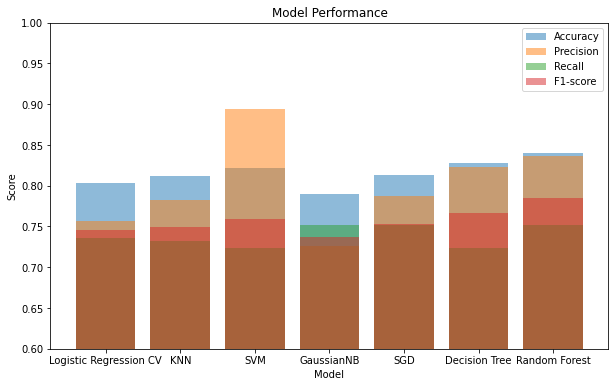

In [85]:
import matplotlib.pyplot as plt

# Get names of models
model_names = [model_results['accuracy'][i]['name'] for i in range(len(model_results['accuracy']))]

# Get scores for each model
accuracy_scores = [model_results['accuracy'][i]['score'] for i in range(len(model_results['accuracy']))]
precision_scores = [model_results['precision'][i]['score'] for i in range(len(model_results['precision']))]
recall_scores = [model_results['recall'][i]['score'] for i in range(len(model_results['recall']))]
f1_scores = [model_results['f1'][i]['score'] for i in range(len(model_results['recall']))]

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Model Performance')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_ylim([0.6,1])

# Plot scores
ax.bar(model_names, accuracy_scores, label='Accuracy', alpha=0.5)
ax.bar(model_names, precision_scores, label='Precision', alpha=0.5)
ax.bar(model_names, recall_scores, label='Recall', alpha=0.5)
ax.bar(model_names, f1_scores, label='F1-score', alpha=0.5)

# Add legend and show plot
ax.legend()
plt.show()

Let's extract our results from the best models for each metric:

In [86]:
for metric in scoring_metrics:
    best_model = max(range(len(model_results[metric])), key=lambda x: model_results[metric][x]['score'])
    print(f"Best {metric} model: {model_results[metric][best_model]['name']}")
    print(f"Score: {model_results[metric][best_model]['score']}")
    print(f"Parameters: {model_results[metric][best_model]['best_params']}")
    print()

Best accuracy model: Random Forest
Score: 0.8401863354037268
Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Best precision model: SVM
Score: 0.8939224722146923
Parameters: {'model__C': 0.1, 'model__kernel': 'poly'}

Best recall model: GaussianNB
Score: 0.7518177163338454
Parameters: {'model__var_smoothing': 1e-09}

Best f1 model: Random Forest
Score: 0.7845246312516785
Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}



Finally, we'll create a file with the target value for each model and we can submit it as a result of our prediction.

In [87]:
X_train = train_df.drop(["Survived", "PassengerId"], axis=1)
Y_train = train_df["Survived"]

model_1 = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200)
model_1.fit(X_train, Y_train)
Y_pred = model_1.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('RFC_1.csv', index=False)

model_2 = SVC(C=0.1, kernel='poly')
model_2.fit(X_train, Y_train)
Y_pred = model_2.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('SVM.csv', index=False)

model_3 = SGDClassifier(alpha=0.1, loss='perceptron', max_iter=2000, penalty='l1')
model_3.fit(X_train, Y_train)
Y_pred = model_3.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('SGD.csv', index=False)

model_4 = RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
model_4.fit(X_train, Y_train)
Y_pred = model_4.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('RFC_2.csv', index=False)

###Links
Kaggle competition - https://www.kaggle.com/competitions/titanic